In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from metrics import *

In [18]:
import boruta

In [19]:
boruta??

In [2]:
def model_loocv_univariable(data, target, model_obj, model_params={}, features=None, metrics=(f1_score)):
    if features is None:
        features = data.columns.copy()
    scores = {metric.__name__:[] for metric in metrics}
    
    for i, col in enumerate(features):
        print(i, end='-')
        model = model_obj(**model_params)
        X = data[[col]]
        y = target.copy()
        
        ytrue, ypred = predict_model_loo(model, X, y)
        
        for metric in metrics:
            score = metric(ytrue, ypred)
            scores[metric.__name__].append(score)
            
        return features, scores
    
def predict_model_loo(model, X, y, proba=False):
    y_pred = []
    y_true = []
    loo = LeaveOneOut()
    
    X = np.array(X)
    y = np.array(y)
    
    if X.ndim == 1:
        X = X[:, np.newaxis]
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        if not proba:
            yi_pred = model.predict(X_test)[0]
        else:
            yi_pred = model.predict_proba(X_test)[0, 1]
        
        y_true.append(y_test[0])
        y_pred.append(yi_pred)
            
    return y_true, y_pred

In [3]:
mat_props = {'square':True, 'annot':True, 'cbar':False, 'lw':1, 
             'cmap':'Reds', 'fmt':'2.0f', 'annot_kws':{'fontsize':24}, 
             'xticklabels': ['Positivo', 'Negativo'], 
             'yticklabels': ['Positivo', 'Negativo']}

In [4]:
data = pd.read_csv('data_preprocess/tran.csv')

In [5]:
columnas_target = ['Group', 'Positivo']
columnas_sintomas = ['Fever', 'Cough', 'Headache', 'Dyspnea', 'Diarrhea',
                     'Chest tightness', 'Chills', 'Pharyngalgia', 'Myalgia', 'Arthralgia',
                     'Arthralgia', 'Rhinorrhea', 'Polypnea', 'Anosmya', 'Dysgeusia']
columnas_clinicos = ['Age', 'Sex', 'Diabetes', 'Hipertension', 'Obesity', 'Smoking']
columnas_lab = list(
    set(data.columns)
    .difference(set(columnas_target + columnas_sintomas + columnas_clinicos))
)

In [6]:
features = columnas_lab.copy()

train_scores_f1 = []
train_scores_acc = []
for i, col in enumerate(features):
    print(i, end='-')
    model = RandomForestClassifier(n_estimators=500, max_depth=6)
    X = data[[col]]
    y = data.Positivo
    
    ytrue, ypred = predict_model_loo(model, X, y)
    score_f1 = f1_score(ytrue, ypred)
    score_acc = balanced_accuracy(ytrue, ypred)
    
    train_scores_f1.append(score_f1)
    train_scores_acc.append(score_acc)

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-

In [8]:
df_unitarios = (
    pd.DataFrame({'feature':features, 'f1':train_scores_f1, 'balanced_accuracy':train_scores_acc})
    .sort_values(by=['balanced_accuracy', 'f1'], ascending=False)
)
df_unitarios.to_csv('out/univariable_rf.csv', index=False)

In [6]:
df_univariable = pd.read_csv('out/univariable_rf.csv')
best_metabolites_uni = list(df_univariable[df_univariable.balanced_accuracy>0.70]["feature"])

In [7]:
model = RandomForestClassifier(n_estimators=500, max_depth=6)

X = data[best_metabolites_uni[1]]
y = data.Positivo

ytrue, ypred = predict_model_loo(model, X, y)

In [10]:
def plot_confusion_matrix(mat, ax=None, title=None, mat_props={}):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    
    sns.heatmap(mat, ax=ax, **mat_props)
    ax.tick_params(labelsize=20)
    ax.set_xlabel('Valor real', fontsize=23, fontweight='bold')
    ax.set_ylabel('Valor predecido', fontsize=23, fontweight='bold')
    
    if title is not None:
        ax.set_title(f'{title}', fontsize=18, fontweight='bold', loc='left')

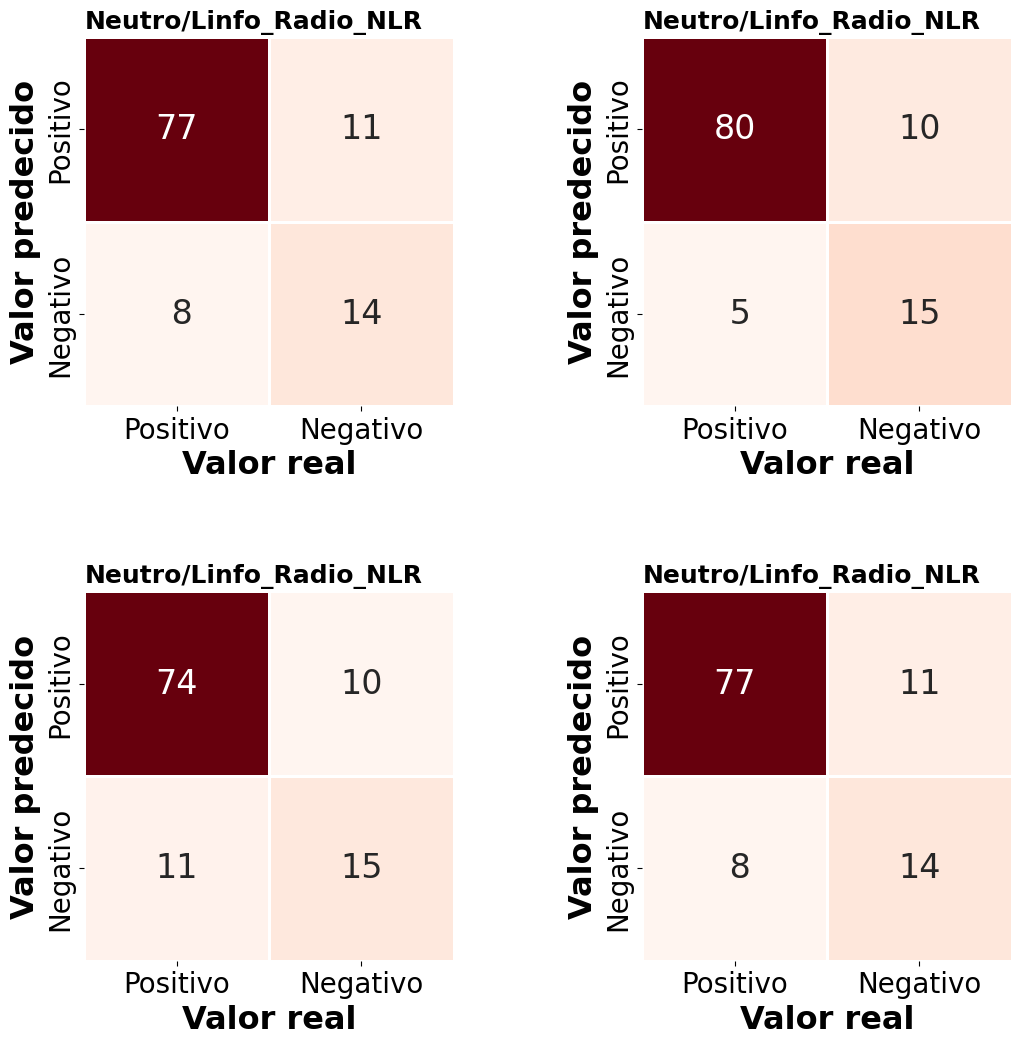

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'wspace':0.5, 'hspace':0.5})

for feature, ax in zip(best_metabolites_uni, axs.ravel()):
    X = data[[feature]]
    y = data.Positivo
    ytrue, ypred = predict_model_loo(model, X, y)
    mat = confusion_matrix(ytrue, ypred)
    plot_confusion_matrix(mat, ax, title=f'{best_metabolites_uni[0]}', mat_props=mat_props)
    
#plt.tight_layout()